In [30]:
#https://docs.scipy.org/doc/scipy/reference/odr.html

#Benotigte Module(inkl. in Anaconda)

import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import *
from scipy.optimize import *
import random
import sys
import scipy.constants as cons
import os

#um es in einer anderen Datei zu verwende:%run ../odr_v3.1.ipynb

#MUSS NICHT ANGEPASST WERDEN
#Funktion welche den Fit durchführt 
def fit(x,y,x_err,y_err,beta0=[1., 0.],fix=[1,1]):
    #definerit die zu fittene Funktion,in B sind die Parameter und x ist die unabhängige
    def lin_func(B, x):
        [m,b]=B
        return m*x+b
    lin_model = Model(lin_func)

    #Überprüft welche Fehler angegeben wurden
    if (np.isnan(x_err).any() and np.isnan(y_err).any()):
        data = RealData(x, y)
    elif np.isnan(x_err).any():
        data = RealData(x, y, sy=y_err)
    elif np.isnan(y_err).any():
        data = RealData(x, y, sx=x_err)
    else:
        data = RealData(x, y, sx=x_err, sy=y_err)
    data.set_meta(lab="Ph 7; Lab 26", title="Ag110 + Ag108 Decay")
    #Führt den Fit aus, beta0 sind die Startwerte
    
    odr = ODR(data, lin_model,beta0,ifixb=fix)
    odr.set_job(fit_type=0)
    out = odr.run()
    #out.beta beinhaltet die Parameter
    #out.sd_beta beinhaltet die Fehler der Parameter
    return out

#Muss nicth angepasst werden es sei denn die Ploteigenschaften sollen geädert werden
def zeichnen (x, y,x_err=np.nan,y_err=np.nan,
              
              #x/y werte mit möglichen fehlern
              
              label="Datapoints",xlabel="x",  ylabel="y",
              #label für die figur
              
              fx_title="f(x)",x_title="x", m_unit="",b_unit="",
              #label für den Titel:
              #fx_title=(m\pm m_err) m_unit *x_title + (b\pm b_err) b_unit
              
              speichername="",save=True,
              #werte zum speichern mit 300dpi als png
              
              beta0=[1., 0.],scientific=[0,0],fix=[1,1],nk=4,
              #startwerte für den linearen fit und die option m/b in scientific form zu schreiben
              
              odr=np.NaN,scale=False,show=True,figsize=(16/1.5,9/1.5)):
              #entweder odr oder curvefit benutzen
              #scale=False: odr scaliert die fehler nicht(so wie bei absolute_sigma=true)
              #use plt.show() wenn False kann man den plot dannach bearbeiten
                
    """zeichnen(x, y, x_err=np.nan, y_err=np.nan, label="f(x)", xlabel="x", ylabel="y", fx_title="f(x)", x_title="x", m_unit="", b_unit="", speichername="", save=True,  beta0=[1., 0.], scientific=[0,0], fix=[1,1], nk=4, odr=False, scale=False, show=True, figsize=(16/1.5,9/1.5)))
    
Die zeichnen-Funktion ermöglicht es einen Plot mit fit zu erstellen
'.' notiert einen Parameter; wenn nicht anders angegeben ist der Typ String 

Mit 'x'/'y' & 'x_err'/'y_err' können die Werte und Fehler gesetzt werden.
    Nur x und y müssen auf jedenfall gegeben werden. Der Rest besitzt default's
Die Achsenlabel werden mittels 'xlabel' & 'ylabel' gesetzt während 'label' das Text in der Legende festsetzt 

Der Titel ist folgendermaßen strukturiert: 'fx_title' = (. \pm .)'m_unit' * x_title + (. \pm .)'b_unit'
Durch int 'nk' können die Nachkommerstellen gesetzt werden 
Durch [int,int] 'scientific' kann eine wissenschaftliche Schreibweise für die Steigung(m) oder den Y-Abschnitt(b) verwendet werden mit den angegeben Nachkommastellen (in der Liste) 

Wenn ein 'speichername' angegeben wird, wird es unter disem abgespeichert mit 300dpi (erweiterung nicht vergessen z.b.: .pdf .png);
mittels bool 'save' kann das speichern unterbunden werden. Die Bildgröße kann mit (float,float) 'figsize' angepasst werden
bool 'show' verhindert zudem das finale zeichenen und ermöglicht nachträgliche Änderungen bei show=False

Durch bool 'odr' kann entschieden werden ob eine "Orthogonal distance regression" verwendet werden soll oder "curve_fit".
Es ist ratsam wenn nur die Y-Fehler angegeben werden, curve_fit zu verwenden(Wird standardweise entscheiden durch die Anwesenheit von x Fehlern)
    bei odr wird das Objekt out zurückgegeben welches mit out.pprint() dargestellt werden kann;
    bei curve_fit wird (popt,pcov) zurückgegeben wobei popt die werte und pcov die Standardabweichung beinhaltet;
    Bemerkung zu odr:
        bool 'scale' deaktiert die Berechnung der Fehler durch odr sondern berechnet sie eigenständig: 
            (scale==False: out.sd_beta=np.sqrt(np.diag(out.cov_beta)))
        scale==False ist äqvivalent zu absolute_sigma=true bei curve_fit und sollte somit unbedingt auf False gelassen werden!
            (unterscheid quasi ob y_err fehler sind(scale==False) oder nur geweichte(scale==True))
        [float,float](m,b) 'beta0' legt die Startwerte für den linearen Fit fest 
        [int,int](m,b) 'fix' ermöglicht es die Startwerte zu fixieren wenn das entsprechende int auf 0 gesetzt wird (nur bei ODR)
        
    """
    #Setzt die odr Variable auf True wenn x fehler nagegeben wurden
    if np.isnan(odr):
        if np.isnan(x_err):
            odr=False
        else:
            odr=True
            
    #Überprüft ob x&y die selbe Länge haben
    if not(len(x)==len(y)):
        sys.exit("Die Länge von x und y stimmen nicht überein")
        
    if (type(x_err)==int or type(x_err)==float or type(x_err)==np.float64):
        x_err=np.full(len(x),x_err)
    if (type(y_err)==int or type(y_err)==float or type(y_err)==np.float64):
        y_err=np.full(len(x),y_err)   
     
    
    #Überprüft welche Fehler angegeben wurden und ihre Länge
    if np.isnan(x_err).any():
        x_err=np.zeros_like(x)
    elif not(len(x)==len(x_err)):
        sys.exit("Die Länge von x und x_err stimmen nicht überein")
        
    if np.isnan(y_err).any():
        y_err=np.zeros_like(x)
    elif not(len(y)==len(y_err)):
        sys.exit("Die Länge von y und y_err stimmen nicht überein")
        
    #Fit ereugen
    if odr:
        out = fit(x,y,x_err,y_err,beta0,fix=fix)
    else:
        def f(x,m,b):
            return m*x+b
        if np.isnan(y_err).any():
            popt, pcov = curve_fit(f, xdata=x,ydata=y,absolute_sigma=True)
        else:
            popt, pcov = curve_fit(f, xdata=x,ydata=y,sigma=y_err,absolute_sigma=True)
        perr = np.sqrt(np.diag(pcov))
    #Fehler für ODR berechnen aus der Kovarianzmatrix
    if (not scale) and odr:
        out.sd_beta=np.sqrt(np.diag(out.cov_beta))
    
    #Steigung und Y abschnitt vereinheitlichen
    if odr:
        steigung=(out.beta[0],out.sd_beta[0])
        yabschnitt=(out.beta[1],out.sd_beta[1])
    else:
        steigung=(popt[0],perr[0])
        yabschnitt=(popt[1],perr[1])
        
    
    chi2,pvalue=chisquare(y,x*steigung[0]+yabschnitt[0])
    print(chi2)
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=figsize)

    #Plottet die Punkte und ihre Fehler
    ax.plot(x, y, "ok", label=label)
    ax.errorbar(x, y, xerr=x_err, yerr=y_err, color="b", fmt='.',capsize=5)#, label=r"$\chi^2/ndf={:.4f}$".format(out.res_var),
    
    #Plottet den Linearen Fit
    ax.plot(x, (steigung[0]*x+yabschnitt[0]), color="k", label="$\chi^2$={:.4f}; p-Value={:.4f}".format(chi2,pvalue))

    
    #x,y label
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    #String für den titel erzeugen
    titlestr=""
    if scientific[0]==0:
        titlestr=titlestr+fx_title+" = ({:.{}f}$\pm${:.{}f})".format(steigung[0],nk,steigung[1],nk)+m_unit+" $\cdot$ "+x_title
    else:
        titlestr=titlestr+fx_title+" = ({:.{}e}$\pm${:.{}e})".format(steigung[0],scientific[0],steigung[1],scientific[0])+m_unit+" $\cdot$ "+x_title
    if scientific[1]==0:
        titlestr=titlestr+" + ({:.{}f}$\pm${:.{}f})".format(yabschnitt[0],nk,yabschnitt[1],nk)+b_unit
    else:
        titlestr=titlestr+" + ({:.{}e}$\pm${:.{}e})".format(yabschnitt[0],scientific[1],yabschnitt[1],scientific[1])+b_unit
        

    
    ax.set_title(titlestr)
    
    ax.grid(b=True, which='major',  linewidth=1)
    ax.grid(b=True, which='minor',  linewidth=0.2)
    ax.minorticks_on()
    ax.legend()
    
    #eventuelles Speichern
    if (bool(save) == True) and not speichername=="" :
        fig.savefig(speichername,dpi=300,bbox_inches = 'tight')

    #Darstellen der Plottes
    if show:
        plt.show()
    #weitergeben der fit Eigenschaften
    if odr:
        return out
    else:
        return popt,perr
def bsp():
    #Beispielwerte für x,y und ihre Fehler, ersetzen in form von ... = np.array([0, 1, 2, 3, 4, 5])
    x = np.array([0, 1, 2, 3, 4, 5])
    y = np.array([i+3 + random.random() -0.5 for i in x])

    x_err = np.array([random.random() for i in x])
    y_err = np.array([random.random() for i in x])

    out=zeichnen (x=x, y=y, x_err=x_err,y_err=y_err, 
                  label="$x(y)$", #name der Punkte in der Legende
                  speichername="Plot_x(y)", 
                  xlabel="$x$", 
                  ylabel="$y$", 
                  fx_title="$f(x)$", #f(x) in dem titel
                  x_title="$x$", #x in dem titel
                  m_unit="$y/x$",
                  b_unit="$x$",
                  save=False) #speichert den Plot mit speichernamen ab
    

1.9317957541136077


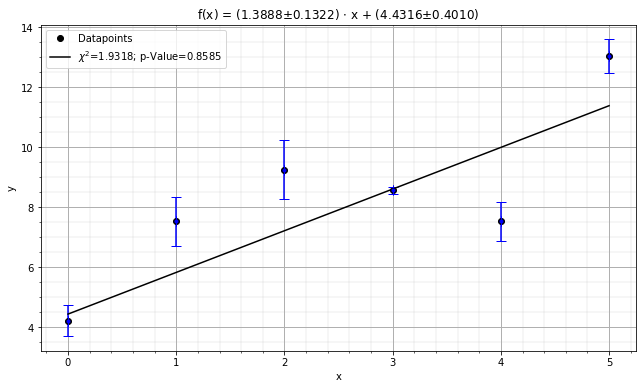

In [33]:
from scipy.stats import chisquare
#Beispielwerte für x,y und ihre Fehler, ersetzen in form von ... = np.array([0, 1, 2, 3, 4, 5])
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([i+3 + 6*random.random() -0.5 for i in x])
y_err = np.array([random.random() for i in x])

out=zeichnen (x=x, y=y,y_err=y_err) #speichert den Plot mit speichernamen ab


In [4]:
def gmw(val,err,mret=True,oret=True):
    #entfernt alle NaN werte aus val und die entsprechenden err werte
    nanind=np.argwhere(np.isnan(val))
    val = np.delete(val, nanind)
    err = np.delete(err, nanind)
    wgt=1/err**2
    m=np.dot(val,wgt)/np.sum(wgt)
    o=1/np.sqrt(np.sum(wgt))
    if mret and (not oret):
        return m
    if oret and (not mret):
        return o
    if oret and mret:
        return m,o

In [5]:
def txt2arr(name,strings=[]):
    """Wandelt die Kopie von google-sheets-werten in einer .txt Datei in ein np.array um. 
    einfach Werte mit strg+c kopieren und in txt einfügen (Kommata werden berücksichtigt)
'name' korespondiert zu dem Dateinamen ohne die Erweiterung .txt.
Es kann eine beliebige Anzahl an collums verwendet werden jedoch müssen sie die selbe Anzahl an rows besitzen.
Alle collum-Nummerierungen, beginnent bei 0, die in list 'strings' vorkommen werden als sttring wiedergegeben.
    z.B.: Bei strings=[0,2] wird das erste und dritte collum als string-array wiedergegeben
    """
    x=np.loadtxt(f"{name}.txt",dtype='<U64',encoding="utf-8")
    if x.ndim == 1:
        if 0 in strings:
            return x
        else:
            return np.array([float(np.char.replace(val,',','.')) for val in x])
#     elif x.shape[1]==2:
#         arr0=np.array([float(np.char.replace(val[0],',','.')) for val in x])
#         arr1=np.array([float(np.char.replace(val[1],',','.')) for val in x])
#         return (arr0,arr1)
    else:
        arr=[]
        for i in range(x.shape[1]):
            if i in strings:
                arr.append(np.array([val[i]for val in x]))
            else:
                arr.append(np.array([float(np.char.replace(val[i],',','.')) for val in x]))
        return arr

In [6]:
def split(value):
    """Gibt Exponent und Mantisse eines Float wieder."""
    exp=int(np.log10(value))
    man=value/10**exp
    return exp, man

In [7]:
def draw(title="",size=(16/1.5,9/1.5),loc="best"):
    k=1.5
    plt.gcf().set_size_inches(size)
    plt.grid(b=True, which='major', linewidth=1)
    plt.grid(b=True, which='minor', linewidth=0.2)
    plt.minorticks_on()
    plt.title(title)
    plt.legend(loc=loc)
    
def save(save=""):
    if os.getlogin()=='alexa':
        plt.savefig(f"A_{save}.pdf",dpi=300,transparent=False)
    elif os.getlogin()=='Lea':
        plt.savefig(f"L_{save}.pdf",dpi=300,transparent=False)
    else:
        plt.savefig(f"{save}.pdf",dpi=300,transparent=False)